<a href="https://colab.research.google.com/github/jhmejia/deep-learning/blob/main/HW6_Part_2_Implementing_CNN_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing CNN using PyTorch

In this notebook, you will:

- Create a mood classifer using the PyTorch Sequential API
- Build a ConvNet to identify sign language digits using the PyTorch nn.Module

After this assignment you will be able to:

- Build and train a ConvNet in PyTorch for a __binary__ classification problem
- Build and train a ConvNet in PyTorch for a __multiclass__ classification problem
- Explain different use cases for the Sequential and nn.Module

First we will need to download some external resources from GitHub. Run the cell below.

In [2]:
!git clone https://github.com/tcuseniordesign/deep-learning-hw6-2.git

Cloning into 'deep-learning-hw6-2'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 28 (delta 0), reused 28 (delta 0), pack-reused 0
Receiving objects: 100% (28/28), 27.78 MiB | 29.45 MiB/s, done.


Then we need to move the resources to the current directory. Run the cell below.

In [3]:
import shutil
import os

source_dir = '/content/deep-learning-hw6-2'
target_dir = '/content'

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

os.rmdir('/content/deep-learning-hw6-2')

## Table of Contents

- [1 - Packages](#1)
- [2 - Smile to Enter](#2)
    - [2.1 - Load the Data and Split the Data into Train/Test Sets](#2-1)
    - [2.2 - Prepare Dataloader](#2-2)
    - [2.3 - Layers in PyTorch](#2-3)
    - [2.4 - The Sequential API](#2-4)
    - [2.5 - Create the Sequential Model](#2-5)
    - [2.6 - Setup loss, optimizer, and evaluation metrics](#2-6)
    - [2.7 - Train and Evaluate the Model](#2-7)
    - [2.8 - Make and Evaluate Random Predictions with Trained Model](#2-8)
- [3 - Hand Sign Recognition](#3)
    - [3.1 - Load the SIGNS Dataset](#3-1)
    - [3.2 - Split the Data into Train/Test Sets](#3-2)
    - [3.3 - Prepare Dataloader](#3-3)
    - [3.4 - Create Neural Net Model by Subclassing nn.Module](#3-4)
    - [3.5 - Setup loss, optimizer, and evaluation metrics](#3-5)
    - [3.6 - Train the Model](#3-6)
    - [3.7 - Make and Evaluate Random Predictions with Trained Model](#3-7)
- [4 - Bibliography](#4)

<a name='1'></a>
## 1 - Packages

As usual, begin by loading in the packages.

In [4]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd

# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from cnn_utils import *
from test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)

<a name='1'></a>
## 2 - Smile to Enter (Binary Classification)
Smile to Enter House is a house in which everybody who enters the house has to be happy; anyone who is not happy, the camera at front door will detect that he is not happy and the door will remain close.

<a name='2-1'></a>
### 2.1 - Load the Data and Split the Data into Train/Test Sets

You'll be using the Smile to Enter dataset for this part of the assignment, which contains images of peoples' faces. Your task will be to build a ConvNet that determines whether the people in the images are smiling or not -- because they only get to enter the house if they're smiling!  

In [5]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255. # X_train.shape is (600, 64, 64, 3) (Number of samples, height, width, channels)
X_test = X_test_orig/255. # X_test.shape is (150, 64, 64, 3) (Number of samples, height, width, channels)

# Reshape X, since PyTorch puts number of channels before height and width
X_train = np.transpose(X_train, (0, 3, 1, 2)) # (600, 3, 64, 64) (Number of samples, channels, height, width)
X_test = np.transpose(X_test, (0, 3, 1, 2)) # (150, 3, 64, 64) (Number of samples, channels, height, width)

# Reshape Y
Y_train = Y_train_orig.T # Y_train.shape is (600, 1)
Y_test = Y_test_orig.T # Y_test.shape is (150, 1)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 3, 64, 64)
Y_train shape: (600, 1)
X_test shape: (150, 3, 64, 64)
Y_test shape: (150, 1)


You can display the images contained in the dataset. Images are **64x64** pixels in RGB format (3 channels).

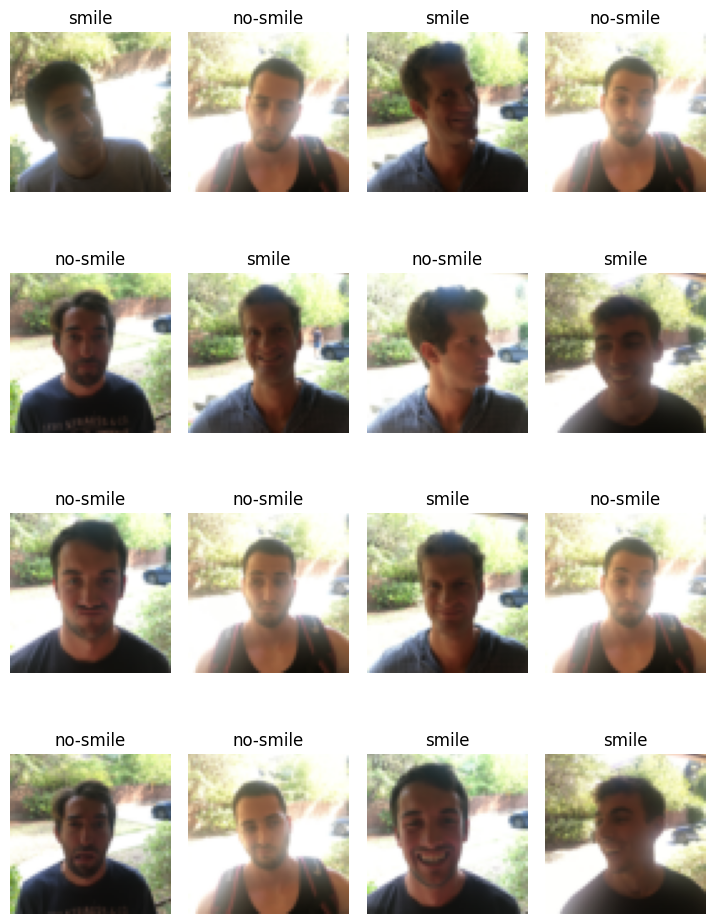

In [6]:
# Plot more images
torch.manual_seed(42)
classes = ['no-smile', 'smile']
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(X_train_orig), size=[1]).item()
    img = X_train_orig[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(classes[Y_train_orig[0, random_idx]])
    plt.axis(False);

<a name='2-2'></a>
### 2.2 - Prepare Dataloader
Now we've got a dataset ready to go. The next step is to turn NumPy dataset to PyTorch dataset, and prepare it with a PyTorch DataLoader.

The DataLoader does what you think it might do. It helps load data into a network for training and for predicting. Simply put, it turns a large Dataset into a Python iterable of smaller chunks.These smaller chunks are called batches or mini-batches and can be set by the batch_size parameter.

Why do this?
Because it's more computationally efficient. In an ideal world, you could do the forward prop and backprop across all of your data at once. But once you start using really large datasets, unless you've got infinite computing power, it's easier to break them up into batches. It also gives your model more opportunities to improve. With mini-batches (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

What's a good batch size?
32 is a good place to start for a fair amount of problems. But since this is a value you can set (a hyperparameter) you can try all different kinds of values, though generally powers of 2 are used most often (e.g. 16, 32, 64, 128, 256, 512).

In [7]:
# Setup the batch size hyperparameter
BATCH_SIZE = 16 # We will use 16 in this example

X_train_tensor = torch.from_numpy(X_train).type(torch.float) # Creates a Tensor from a numpy.ndarray
Y_train_tensor = torch.from_numpy(Y_train).type(torch.float) # Creates a Tensor from a numpy.ndarray

X_test_tensor = torch.from_numpy(X_test).type(torch.float) # Creates a Tensor from a numpy.ndarray
Y_test_tensor = torch.from_numpy(Y_test).type(torch.float) # Creates a Tensor from a numpy.ndarray

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

<a name='2-3'></a>
### 2.3 - Layers in PyTorch

In the first part of this homework, you created layers manually in NumPy. In PyTorch, you don't have to write code directly to create layers. Rather, PyTorch has pre-defined layers you can use.

When you create a layer in PyTorch, you are creating a function that takes some input and transforms it into an output you can reuse later. Nice and easy!

<a name='2-4'></a>
### 2.4 - The Sequential API

In part 1 of this homework, you built helper functions using NumPy to understand the mechanics behind convolutional neural networks. Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call. PyTorch allows for even more simplified and optimized model creation and training.

Next, you'll first create a model using PyTorch Sequential API, which allows you to build layer by layer, and is ideal for building models where each layer has **exactly one** input tensor and **one** output tensor.

As you'll see, using the Sequential API is simple and straightforward, but is only appropriate for simpler, more straightforward tasks. Later in this notebook you'll spend some time building with a more flexible, powerful alternative: the nn.Module.


<a name='2-5'></a>
### 2.5 - Create the Sequential Model

As mentioned earlier, the PyTorch Sequential API can be used to build simple models with layer operations that proceed in a sequential order.

Actually, you can think of a Sequential model as behaving like a list of layers. Like Python lists, Sequential layers are ordered, and the order in which they are specified matters. If your model is non-linear or contains layers with multiple inputs or outputs, a Sequential model wouldn't be the right choice!

Implement the `happyModel` function below to build the following model: `ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. Take help from [torch.nn](https://pytorch.org/docs/stable/nn.html)

Also, plug in the following parameters for all the steps:

 - [ZeroPad2d](https://pytorch.org/docs/stable/generated/torch.nn.ZeroPad2d.html): padding 3, input shape 64 x 64 x 3
 - [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html): Use 32 7x7 filters, stride 1, padding 0
 - [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html): input should be the same as the number of channels in the previous layer
 - [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
 - [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html): 2 x 2
 - [Flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html) compresses the dimensions of a tensor into a single vector.
 - Fully-connected ([Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) layer: a fully connected layer with 1 output neuron

In [8]:
from torch.nn.modules.activation import ReLU
# GRADED FUNCTION: happyModel

def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZeroPad2d -> Conv2d -> BatchNorm2d -> ReLU -> MaxPool2d -> Flatten -> Linear

    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. Normally, functions should take these values as function parameters.

    Arguments:
    None

    Returns:
    model -- PyTorch model
    """
    model = nn.Sequential(
            # YOUR CODE STARTS HERE
            ## ZeroPadding2D with padding 3, input shape of 3x 64 x 64
            nn.ZeroPad2d(3),
            ## Conv2D with 32 7x7 filters and stride of 1
            nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=0),
            # BatchNorm2d
            nn.BatchNorm2d(32),

            ## ReLU
            nn.ReLU(),

            ## Max Pooling 2D
            nn.MaxPool2d(kernel_size=2),

            ## Flatten layer
            nn.Flatten(),

            ## Dense layer with 1 unit for output

            nn.Linear(32 * 32 * 32 , 1)
            # YOUR CODE ENDS HERE
        )

    return model

In [9]:
happy_model = happyModel()

# Print a summary for each layer
print(happy_model)

Sequential(
  (0): ZeroPad2d((3, 3, 3, 3))
  (1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=32768, out_features=1, bias=True)
)


<a name='2-6'></a>
### 2.6 - Setup loss, optimizer, and evaluation metrics

Now that your model is created, we need to pick a loss function and an optimizer for training purposes.

For a binary classification problem (like ours), you'll often use [Binary Cross Entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) as the loss function.

PyTorch has two binary cross entropy implementations:
1. [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) - This is the same as above except it has a sigmoid layer ([`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)) built-in (we'll see what this means soon).

Which one should you use?

The documentation for [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer. So generally, `torch.nn.BCEWithLogitsLoss()` is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()` but that is beyond the scope of this homework.

Knowing this, let's create a loss function and an optimizer.

For the optimizer we'll use `torch.optim.Adam()` to optimize the model parameters with learning rate 1e-3.

> **Note:** There's a [discussion on the PyTorch forums about the use of `nn.BCELoss` vs. `nn.BCEWithLogitsLoss`](https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/4). It can be confusing at first but as with many things, it becomes easier with practice.

In [10]:
#Set up loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in
optimizer = torch.optim.Adam(happy_model.parameters(), lr=1e-3)

To measure the training time, we will define a helper function. Our timing function will import the [`timeit.default_timer()` function](https://docs.python.org/3/library/timeit.html#timeit.default_timer) from the Python [`timeit` module](https://docs.python.org/3/library/timeit.html).

In [11]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

Now let's also create an evaluation metric.

An evaluation metric can be used to offer another perspective on how your model is going.

If a loss function measures how wrong your model is, then think of evaluation metrics as measuring how right it is. Of course, you could argue both of these are doing the same thing but evaluation metrics offer a different perspective. After all, when evaluating your models it's good to look at things from multiple points of view.

There are several evaluation metrics that can be used for classification problems but let's start out with accuracy. Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions. For example, a model that makes 99 correct predictions out of 100 will have an accuracy of 99%.

Let's write a function to do so.

In [12]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

Excellent! We can now use this function whilst training our model to measure it's performance alongside the loss.

<a name='2-7'></a>
### 2.7 - Train and Evaluate the Model

Looks like we've got all of the pieces of the puzzle ready to go, a timer, a loss function, an optimizer, a model, and most importantly, data.

Our data batches are contained within our `DataLoader`s: `train_dataloader` and `test_dataloader` for the training and test data splits respectively.

A batch is `BATCH_SIZE` samples of `X` (features) and `y` (labels), since we're using `BATCH_SIZE=16`, our batches have 16 samples of images and targets.

Since we're computing on batches of data, our loss and evaluation metrics (accuracy in this example) will be calculated **per batch** rather than across the whole dataset. This means we'll have to divide our loss and accuracy values by the number of batches in each dataset's respective dataloader.

Here is the gist of the training algorithm. Let's step through it:
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out some intermediate results like loss and accuracy.
5. Time the training.

Look at step 2. Do you remember the steps in a PyTorch training loop?

If not, here's a reminder.

Steps in training:

<details>
    <summary>PyTorch training loop steps</summary>
    <ol>
        <li><b>Forward pass</b> - The model goes through all of the training data once, performing its
            <code>forward()</code> function
            calculations (<code>model(x_train)</code>).
        </li>
        <li><b>Calculate the loss</b> - The model's outputs (predictions) are compared to the ground truth and evaluated
            to see how
            wrong they are (<code>loss = loss_fn(y_pred, y_train</code>).</li>
        <li><b>Zero gradients</b> - The optimizers gradients are set to zero (they are accumulated by default) so they
            can be
            recalculated for the specific training step (<code>optimizer.zero_grad()</code>).</li>
        <li><b>Perform backpropagation on the loss</b> - Computes the gradient of the loss with respect for every model
            parameter to
            be updated (each parameter
            with <code>requires_grad=True</code>). This is known as <b>backpropagation</b>, hence "backwards"
            (<code>loss.backward()</code>).</li>
        <li><b>Step the optimizer (gradient descent)</b> - Update the parameters with <code>requires_grad=True</code>
            with respect to the loss
            gradients in order to improve them (<code>optimizer.step()</code>).</li>
    </ol>
</details>

In [13]:

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 20

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss, train_acc = 0, 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        happy_model.train()
        # 1. Forward pass
        # YOUR CODE STARTS HERE
        y_pred = torch.round(torch.sigmoid(happy_model(X)))

        # YOUR CODE ENDS HERE

        # 2. Calculate loss (per batch)
        # YOUR CODE STARTS HERE
        loss = loss_fn(y_pred, y)

        # YOUR CODE ENDS HERE
        train_loss += loss # accumulatively add up the loss for each batch
        train_acc += accuracy_fn(y_true=y, # accumulatively add up the accuracy for each batch
                                y_pred=y_pred)

        # 3. Optimizer zero grad
        # YOUR CODE STARTS HERE
        optimizer.zero_grad()

        # YOUR CODE ENDS HERE

        # 4. Loss backward
        # YOUR CODE STARTS HERE
        loss.backward()

        # YOUR CODE ENDS HERE

        # 5. Optimizer step
        # YOUR CODE STARTS HERE
        optimizer.step()

        # YOUR CODE ENDS HERE

        # Print out how many samples have been seen
        if batch % 10 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Compute the avg loss and avg accuracy for this epoch by dividing total train loss and
    # train accuray by length of train dataloader
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    happy_model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = torch.round(torch.sigmoid(happy_model(X)))

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss for each batch

            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out the result for each epoch
    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(happy_model.parameters()).device))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/600 samples
Looked at 160/600 samples
Looked at 320/600 samples
Looked at 480/600 samples

Train loss: 0.77944 | Train accuracy: 55.10% | Test loss: 0.71946, Test acc: 61.04%

Epoch: 1
-------
Looked at 0/600 samples
Looked at 160/600 samples
Looked at 320/600 samples
Looked at 480/600 samples

Train loss: 0.78171 | Train accuracy: 54.77% | Test loss: 0.71955, Test acc: 61.67%

Epoch: 2
-------
Looked at 0/600 samples
Looked at 160/600 samples
Looked at 320/600 samples
Looked at 480/600 samples

Train loss: 0.78829 | Train accuracy: 53.78% | Test loss: 0.70913, Test acc: 62.71%

Epoch: 3
-------
Looked at 0/600 samples
Looked at 160/600 samples
Looked at 320/600 samples
Looked at 480/600 samples

Train loss: 0.78108 | Train accuracy: 54.77% | Test loss: 0.71559, Test acc: 61.67%

Epoch: 4
-------
Looked at 0/600 samples
Looked at 160/600 samples
Looked at 320/600 samples
Looked at 480/600 samples

Train loss: 0.78335 | Train accuracy: 54.44% | Test loss: 0.

<a name='2-8'></a>
### 2.8 - Make and Evaluate Random Predictions with Trained Model

We are doing very well on both training and testing set. Next, let's create a function make_predictions() where we can pass the model and some random test data for it to predict on.

In [14]:
class_names =  ['no-smile', 'smile']

In [15]:
def make_predictions(model: torch.nn.Module, data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0) # Add an extra dimension (3, 64, 64) -> (1, 3, 64, 64)

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample) # pred_logit.shape is (1, 1)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.sigmoid(pred_logit.squeeze())

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

Let's prepare some random data from the test_dataset.

In [16]:
import random
random.seed(43)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9): # get 9 random samples from test_dataset
    test_samples.append(sample)
    test_labels.append(label.item())

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[int(test_labels[0])]})")

Test sample image shape: torch.Size([3, 64, 64])
Test sample label: 0.0 (no-smile)


And now we can use our `make_predictions()` function to predict on `test_samples`.

In [17]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=happy_model,
                             data=test_samples) # ()

# View first two prediction probabilities list
pred_probs[:2]

tensor([0.5651, 0.5879])

Excellent!

And now we can go from prediction probabilities to prediction labels by rounding the probabilities.

In [18]:
# Turn the prediction probabilities into prediction labels by rounding
pred_classes = torch.round(pred_probs)
pred_classes

tensor([1., 1., 1., 1., 1., 0., 1., 1., 1.])

In [19]:
test_labels

[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]

In [20]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0],
 tensor([1., 1., 1., 1., 1., 0., 1., 1., 1.]))

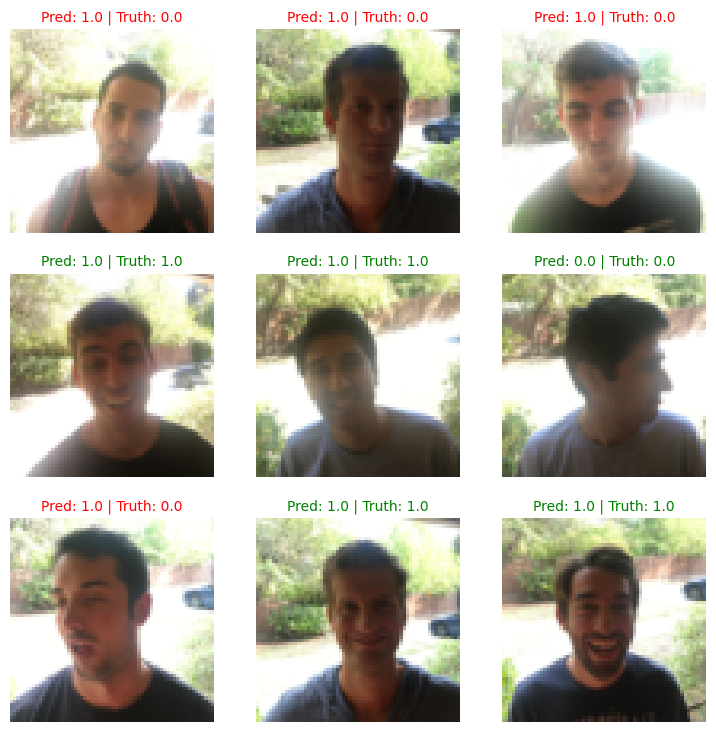

In [21]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  sample = sample.swapaxes(0, 1)
  sample = sample.swapaxes(1, 2)
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label
  pred_label = pred_classes[i]

  # Get the truth label
  truth_label = test_labels[i]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

Easy, right? Not bad for a couple dozen lines of PyTorch code!

But what if you need to build a model with shared layers, branches, or multiple inputs and outputs? This is where Sequential, with its beautifully simple yet limited functionality, won't be able to help you.

Next up: nn.Module.  

<a name='3'></a>
## 3 - Hand Sign Recognition (Multiclass Classification)

In this part, you'll use PyTorch's [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) to build a ConvNet that can differentiate between 6 sign language digits. This is a multiclass classification task.

nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order. So if you'd something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

`torch.nn.Module` is the base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. It requires a forward() method be implemented.

The `torch.nn.Module` can handle models with non-linear topology, shared layers, as well as layers with multiple inputs or outputs. Imagine that, where the Sequential API requires the model to move in a linear fashion through its layers, the `torch.nn.Module` allows much more flexibility. Where Sequential is a straight line, a `torch.nn.Module` model is a graph, where the nodes of the layers can connect in many more ways than one.

In the visual example below, the one possible direction of the movement Sequential model is shown in contrast to a skip connection, which is just one of the many ways a model can be constructed. A skip connection, as you might have guessed, skips some layer in the network and feeds the output to a later layer in the network. Don't worry, you'll be spending more time with skip connections very soon!

<img src="https://raw.githubusercontent.com/tcuseniordesign/deep-learning-hw6-2/main/images/seq_vs_func.png" style="width:350px;height:200px;">

<a name='3-1'></a>
### 3.1 - Load the SIGNS Dataset

As a reminder, the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

In [22]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

<img src="https://raw.githubusercontent.com/tcuseniordesign/deep-learning-hw6-2/main/images/SIGNS.png" style="width:800px;height:300px;">

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples.

y = 2


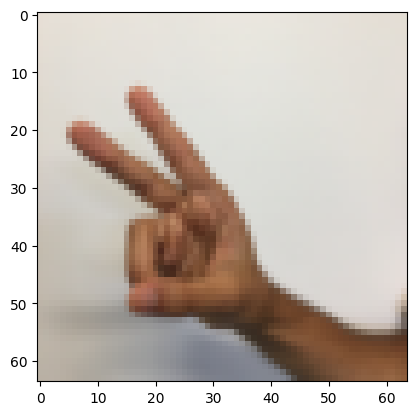

In [23]:
# Example of an image from the dataset
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

<a name='3-2'></a>
### 3.2 - Split the Data into Train/Test Sets

To get started, let's examine the shapes of your data.

In [24]:
print(X_train_orig.shape)
print(Y_train_orig.shape)

# What does Y look like? It stores the class labels, e.g., 0, 1, 2, 3, 4, 5, not one-hot vectors
print(Y_train_orig)

(1080, 64, 64, 3)
(1, 1080)
[[5 0 2 ... 2 4 5]]


In [25]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert Y to one hot vector for training purpose
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

# Reshape X, since PyTorch puts number of channels before height and width
X_train = np.transpose(X_train, (0, 3, 1, 2)) # (Number of samples, channels, height, width)
X_test = np.transpose(X_test, (0, 3, 1, 2)) # (Number of samples, channels, height, width)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 3, 64, 64)
Y_train shape: (1080, 6)
X_test shape: (120, 3, 64, 64)
Y_test shape: (120, 6)


<a name='3-3'></a>
### 3.3 - Prepare Dataloader

In [26]:
# Setup the batch size hyperparameter
BATCH_SIZE = 64

X_train_tensor = torch.from_numpy(X_train).type(torch.float)
Y_train_tensor = torch.from_numpy(Y_train).type(torch.float)

X_test_tensor = torch.from_numpy(X_test).type(torch.float)
Y_test_tensor = torch.from_numpy(Y_test).type(torch.float)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

<a name='3-4'></a>
### 3.4 - Create Neural Net Model by Subclassing nn.Module
Our goal is to create a CNN like this: `Conv2D -> ReLU -> MaxPool2d -> Conv2D -> ReLU -> MaxPool2d -> Flatern -> Linear`

Here are the steps:
1. Create a class called `SignModel` which subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`).
2. Define 4 layers in the constructor capable of handling the input and output shapes of `X` and `y`.
  1. self.conv1: `Conv2D -> ReLU -> MaxPool2d`
  2. self.conv2: `Conv2D -> ReLU -> MaxPool2d`
  3. self.flattern: one flattern layer: `Flatern`
  4. self.fc: one Linear layer: `Linear`
3. Defines a `forward()` method containing the forward pass computation of the CNN. Note, any subclass of `nn.Module` must override this `forward()` method.

The first two layers (self.conv1 and self.conv2) can be constructed using the sequential API you have learned.

Also, plug in the following parameters for all the steps:

 - [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html): Use 8 4 by 4 filters, stride 1, padding is "SAME"
 - [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
 - [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html): Use an 8 by 8 filter size and an 8 by 8 stride
 - **Conv2D**: Use 16 2 by 2 filters, stride 1, padding is "SAME"
 - **ReLU**
 - **MaxPool2d**: Use a 4 by 4 filter size and a 4 by 4 stride
 - [Flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html) the previous output.
 - Fully-connected ([Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) layer: Apply a fully connected layer with 6 neurons.

 Then, in the forward() method.

In [27]:
# Create a convolutional neural network
import torch.nn as nn
import torch.nn.functional as F

class SignModel(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE STARTS HERE
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=1, padding='same'), # 'same' padding
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8, stride=8)
        )

        # Define the second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=4, stride=1, padding='same'), # 'same' padding
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )

        # Define the flattening layer
        self.flatten = nn.Flatten() # why is this misspelled aha

        # Define the fully connected layer
        self.fc = nn.Linear(64, 6)  # 64 input features, 6 output features


        # YOUR CODE ENDS HERE
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

Instantiates the model class.

In [28]:
sign_model = SignModel()

In [29]:
sign_model

SignModel(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

<a name='3-5'></a>
### 3.5 - Setup loss, optimizer, and evaluation metrics

Now that your model is created, we need to pick a loss function and an optimizer for training purposes.

For a multiclass classification problem (like ours), you'll often use Cross Entropy as the loss function.

[`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) creates a loss function that measures the cross entropy between input logits and target. The input is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general).

Knowing this, let's create a loss function and an optimizer.

For the optimizer we'll use `torch.optim.Adam()` to optimize the model parameters with learning rate 1e-3.

In [30]:
#Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sign_model.parameters(), lr=1e-3)

Now let's also create an evaluation metric. The accuracy function is different from the one we used in binary classification task.

In [31]:
# Calculate accuracy (a classification metric)
def accuracy(y_true, y_pred_logits):
    correct = torch.eq(y_true.argmax(dim=1), y_pred_logits.argmax(dim=1)).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred_logits)) * 100
    return acc

<a name='4-4'></a>
### 3.6 - Train the Model

In [33]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 100

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss, train_acc = 0, 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        sign_model.train()
        # 1. Forward pass
        # YOUR CODE STARTS HERE
        y_logits = sign_model(X)

        # print(y_logits.shape) # torch.Size([16, 6])
        # print(y.shape) # torch.Size([16, 1])
        # y = y.expand(16, 6)
        # YOUR CODE ENDS HERE
        # 2. Calculate loss (per batch)
        # YOUR CODE STARTS HERE
        loss = loss_fn(y_logits, y)
        # multiply y by 6 to be per batch.



        # YOUR CODE ENDS HERE
        train_loss += loss # accumulatively add up the loss per epoch
        train_acc += accuracy(y_true=y,
                                y_pred_logits=y_logits)

        # 3. Optimizer zero grad
        # YOUR CODE STARTS HERE
        optimizer.zero_grad()
        # YOUR CODE ENDS HERE

        # 4. Loss backward
        # YOUR CODE STARTS HERE
        loss.backward()
        # YOUR CODE ENDS HERE

        # 5. Optimizer step
        # YOUR CODE STARTS HERE
        optimizer.step()
        # YOUR CODE ENDS HERE

        # Print out how many samples have been seen
        if batch % 10 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss and train accuray by length of train dataloader (per batch)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    sign_model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_logits = sign_model(X)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_logits, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy(y_true=y, y_pred_logits=test_logits)

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(sign_model.parameters()).device))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/1080 samples
Looked at 640/1080 samples

Train loss: 0.33490 | Train accuracy: 91.19% | Test loss: 0.40689, Test acc: 87.95%

Epoch: 1
-------
Looked at 0/1080 samples
Looked at 640/1080 samples

Train loss: 0.34757 | Train accuracy: 90.23% | Test loss: 0.43976, Test acc: 85.49%

Epoch: 2
-------
Looked at 0/1080 samples
Looked at 640/1080 samples

Train loss: 0.33111 | Train accuracy: 91.36% | Test loss: 0.42461, Test acc: 83.48%

Epoch: 3
-------
Looked at 0/1080 samples
Looked at 640/1080 samples

Train loss: 0.33462 | Train accuracy: 91.40% | Test loss: 0.39625, Test acc: 84.49%

Epoch: 4
-------
Looked at 0/1080 samples
Looked at 640/1080 samples

Train loss: 0.31453 | Train accuracy: 91.50% | Test loss: 0.42741, Test acc: 85.04%

Epoch: 5
-------
Looked at 0/1080 samples
Looked at 640/1080 samples

Train loss: 0.30050 | Train accuracy: 92.41% | Test loss: 0.39143, Test acc: 85.71%

Epoch: 6
-------
Looked at 0/1080 samples
Looked at 640/1080 samples



<a name='5'></a>
### 3.7 - Make and Evaluate Random Predictions with Trained Model

Next, let's create a function make_predictions() where we can pass the model and some randome test data for it to predict on.

In [34]:
def make_predictions(model: torch.nn.Module, data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0) # Add an extra dimension

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

Let's prepare some randome data from the test_dataset.

In [35]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label.argmax().item())

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({test_labels[0]})")

Test sample image shape: torch.Size([3, 64, 64])
Test sample label: 0 (0)


And now we can use our `make_predictions()` function to predict on `test_samples`.

In [36]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=sign_model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[9.9999e-01, 1.3437e-07, 1.9880e-06, 1.3014e-06, 9.5484e-06, 8.8208e-07],
        [9.3074e-05, 9.9912e-01, 3.3415e-04, 4.1996e-04, 2.1777e-05, 1.1933e-05]])

Excellent!

And now we can go from prediction probabilities to prediction labels by taking the `torch.argmax()` of the output of the `torch.softmax()` activation function.

In [37]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 1, 5, 5, 1, 1, 1, 4, 1])

In [38]:
test_labels

[0, 1, 5, 5, 1, 1, 1, 4, 1]

In [39]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([0, 1, 5, 5, 1, 1, 1, 4, 1], tensor([0, 1, 5, 5, 1, 1, 1, 4, 1]))

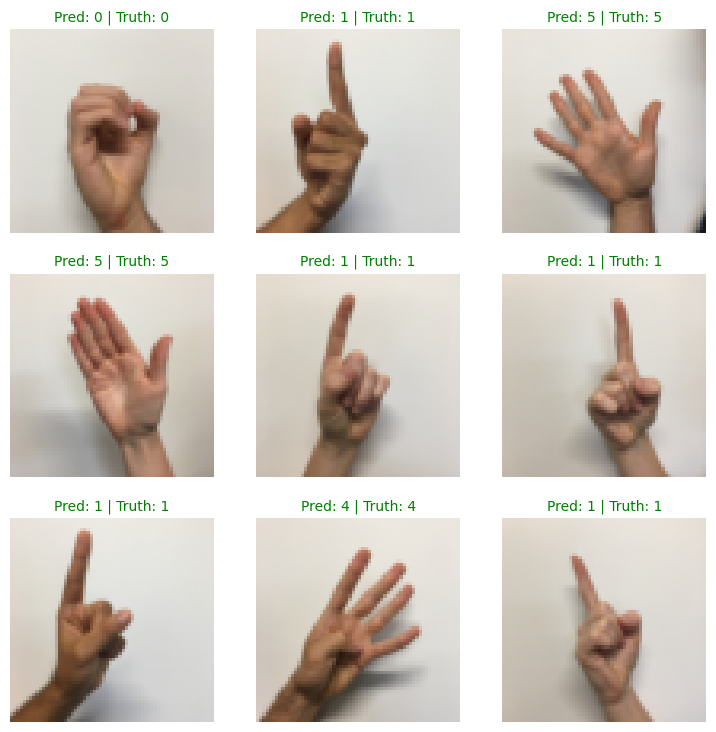

In [40]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  sample = sample.swapaxes(0, 1)
  sample = sample.swapaxes(1, 2)
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = pred_classes[i]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = test_labels[i]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

**Congratulations**! You've finished the assignment and built two models: One that recognizes  smiles, and another that recognizes SIGN language with almost 90% accuracy on the test set. Nicely done!

By now, you know a bit about how PyTorch works and may have glimpsed the possibilities. In your next homework, you'll really get a feel for its power when you get the opportunity to build a very deep ConvNet, using ResNets!

<a name='4'></a>
## 4 - Bibliography

You're always encouraged to read the official documentation. To that end, you can find the docs for the PyTorch here:

https://pytorch.org/docs/stable/index.html